Load all required libraries for preprocessing, lemmatization, vectorization, and feature engineering

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import re, string, contractions, textstat
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [2]:
df = pd.read_csv("../data/preprocessed/master_stance.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Headline                     49972 non-null  object 
 1   Body ID                      49972 non-null  int64  
 2   Stance                       49972 non-null  object 
 3   articleBody                  49972 non-null  object 
 4   headline_len_chars           49972 non-null  int64  
 5   headline_len_words           49972 non-null  int64  
 6   body_len_chars               49972 non-null  int64  
 7   body_len_words               49972 non-null  int64  
 8   headline_body_overlap_ratio  49972 non-null  float64
 9   cosine_sim                   49972 non-null  float64
 10  headline_sentiment           49972 non-null  float64
 11  body_sentiment               49972 non-null  float64
 12  readability                  49972 non-null  float64
dtypes: float64(5), i

Fix contractions and remove extra whitespace for both headline and body

Remove non-letter characters, lowercase, remove stopwords, and lemmatize tokens

In [4]:
def normalize_text(text):
    text = contractions.fix(str(text))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [5]:
wnl = WordNetLemmatizer()
stop = set(stopwords.words("english"))

In [6]:
def clean_text(text):
    text = re.sub("[^a-zA-Z]", " ", str(text))
    text = text.lower().split()
    text = [wnl.lemmatize(word) for word in text if word not in stop]
    return " ".join(text)

In [7]:
df["headline_prep"] = df["Headline"].apply(normalize_text).apply(clean_text)

In [8]:
df["body_prep"] = df["articleBody"].apply(normalize_text).apply(clean_text)

In [9]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser"])

In [10]:
texts = df["body_prep"].fillna("").tolist()
entity_counts = [len(doc.ents) for doc in nlp.pipe(texts, batch_size=100)]

C:\Users\Owner\PycharmProjects\TrustNet\.venv\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [11]:
df["entity_count"] = entity_counts

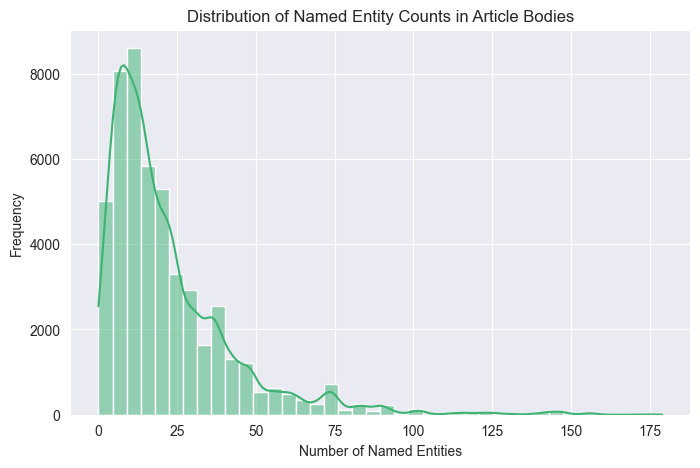

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(df["entity_count"], bins=40, kde=True, color="mediumseagreen")
plt.title("Distribution of Named Entity Counts in Article Bodies")
plt.xlabel("Number of Named Entities")
plt.ylabel("Frequency")
plt.show()

It seems that there are a lot of text that have very few entities, which might represent real news since they richer in factual content. Very few text is made of many entities, which might be due to longer news article or summary of multiple events

C:\Users\Owner\AppData\Local\Temp\ipykernel_36156\1982972378.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Stance", y="entity_count", palette="Set2")


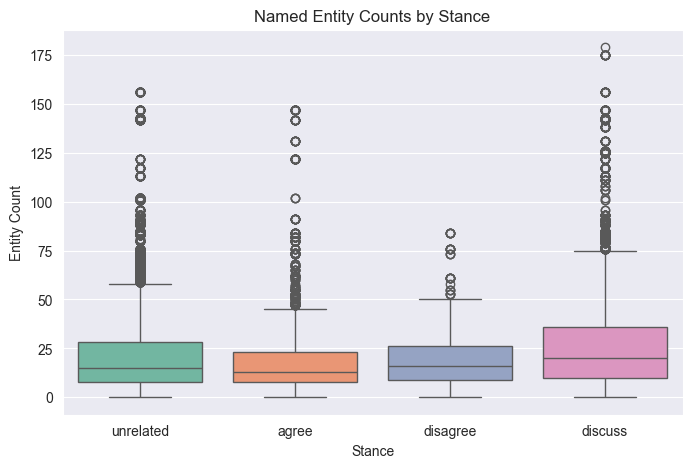

In [25]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Stance", y="entity_count", palette="Set2")
plt.title("Named Entity Counts by Stance")
plt.xlabel("Stance")
plt.ylabel("Entity Count")
plt.show()

Across all classes we can see a lot of outliers which may lead to noise when modeling, so we really should normalize it. Discuss has the highest number of entities which makes sense since the goal of the article is to discuss the headline. Unrelated has the lowest number of entity, which can be a clue when sorting our testing data.

Combine cleaned headline and body into a single field for TF-IDF vectorization

In [12]:
df["combined_text"] = df["headline_prep"] + " " + df["body_prep"]

In [13]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [14]:
X_tfidf = tfidf.fit_transform(df["combined_text"])

Select quantitative features  from earlier EDA for model input

In [16]:
numeric_cols = [
    "headline_len_words",
    "body_len_words",
    "cosine_sim",
    "headline_sentiment",
    "body_sentiment",
    "readability",
    "headline_body_overlap_ratio",
    "entity_count"
]

Merge TF-IDF features with numeric side features for full model input

In [17]:
numeric_feats = df[numeric_cols].fillna(0).values

In [18]:
X_full = hstack([X_tfidf, numeric_feats])

Transform the categorical labels into numerical for ML purposes

In [19]:
stance_map = {"agree": 0, "disagree": 1, "discuss": 2, "unrelated": 3}

In [20]:
df["stance_label"] = df["Stance"].map(stance_map)

In [21]:
df.to_csv("../data/preprocessed/stance_preprocessed.csv", index=False)